### Preparation

#### 1.1 Import library

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import polars as pl

from src.lib.etl.class_ETL import ETL
from src.lib.frc_model.class_Forecast_Model import Forecast_Model

pd.options.display.float_format = '{:,}'.format
pd.options.display.max_columns = 100

In [2]:
###########################################################################################################################################################################################################################################
##  What can triendt can do for you? let type: triendt and the dot like "triendt."    
##                                                                                                                                               
##  As you can see, triendt has 4 functions which are:                                                                                                                                                                               
##      1. triendt.extract_bigquery_data(start_date=, table_name= )                                                                                                                                                                  
##      2. triendt.extract_local_data(table_name=)                                                                                                                                                                                   
##      3. triendt.ingest_data_to_sqlite(data_ingest=, table_name=)                                                                                                                                                                  
##      4. triendt.auto_ingest_data(table_name=)                                                                                                                                                                                     
###########################################################################################################################################################################################################################################
## 1. function extract_bigquery_data
##    >> extract data from an sql file, which is saved in create_database folder.  If you want to extract another table, create a file contains sql script, save it with the table_name.sql and store it in create_database folder
##    >> start_date is the date that you want to view
##    >> table_name is the name of the file, you can think of a sql file like a metabase card withou filter anything.
## 
## 2. function extract_local_data
##    >> extract data from fa_database.db file, you can check it out at this link (https://sqliteviewer.app/) to see which table already exists in local db
##    >> table_name is the name of table already has data locally   
##
## 3. ingest_data_to_sqlite 
##    >> use to insert data local, avoid being updated lately.
##    >> table_name is the name of table already has data locally   
## Note: Carefully when use it funcion, because this function allow use insert data without check out whether new data to insert already exist in DB. As a result, data could be duplicated, and downstreaming purpose would be incorect.
##
## 4. auto_ingest_data
##    >> use this function to update data in database locally without being afraid of data duplicate
##    >> data will be updated with current date - 1 day. 
############################################################################################################################################################################################################################################

#### 1.2 Create udf - user defined function

In [3]:
def filter_data_input(df, frc_value, cond):
    
    # fitler your df
    if cond:
        for _key, _values in cond.items():
            df = df[df[_key] == _values ]
    
    df_pivot = df.groupby(['complete_date'],as_index = False)[frc_value].sum()
    df_pivot.sort_values('complete_date',inplace= True)

    return df_pivot

### Forecast

In [4]:
# call triendt to handle import, export data
triendt = ETL(credentials_file_path= './../../config/cred.json',
              local_database= './data/database/fa_database.db'
              )

In [5]:
# df_bigquery_data = triendt.extract_bigquery_data(start_date= '2024-05-07', table_name= 'fct_fa_pnl_mini')
# df_bigquery_data

##### 2.1 Check if historical data exists 
* If your local database is not update data yet. Just use function auto_updat_data above

In [6]:
df_fa_pnl_mini = triendt.extract_local_data(table_name='fct_fa_pnl_mini')
df_fa_pnl_mini.complete_date = pd.to_datetime(df_fa_pnl_mini.complete_date, format='mixed')
df_fa_pnl_mini.tail()

,complete_date,province,service_type,customer_type,partner,project,gsv_excluded_vat,stoppoint,aha_revenue,created_at
20353688,2024-05-07,vca,bike,sme,84706709985,expansion,"21,814.814814814814",1.0,"4,999.999999999999",2024-05-08 23:14:16.332847
20353689,2024-05-07,sgn,bike,sme,84932333214,core,"21,296.296296296296",1.0,"4,999.999999999999",2024-05-08 23:14:16.332847
20353690,2024-05-07,sgn,bike,sme,84352049945,core,"21,296.296296296296",1.0,"4,999.999999999999",2024-05-08 23:14:16.332847
20353691,2024-05-07,sgn,bike,sme,84388169678,core,"21,296.296296296296",1.0,"4,999.999999999999",2024-05-08 23:14:16.332847
20353692,2024-05-07,han,bike,sme,84888089996,core,"21,296.296296296296",1.0,"4,999.999999999999",2024-05-08 23:14:16.332847


In [7]:
## to delete all data and update whole table, choose update_type = 'update_as_new'
triendt.auto_update_data(table_name='fct_fa_pnl_mini', update_type='append')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Start fetching data from bigquery at : 2024-05-08 23:50:32.380776 

Finished fetching data from bigquery at: 2024-05-08 23:50:32.381364 

Start insert data from bigquery at : 2024-05-08 23:50:33.388094 

Finished insert data from bigquery at: 2024-05-08 23:50:38.086554 

Start ingest data into table: fct_fa_pnl_mini
Update data sucessfully !!!


##### 2.2 Input filter condition below and change your df name with condition.

In [8]:
# filter_conditions = {"province": "han",
#                      "service_type": "truck",
#                      }

filter_conditions = None

df_historical_data = filter_data_input(df= df_fa_pnl_mini,frc_value= 'stoppoint', cond= filter_conditions)

### call forecast model
forecast_gsv_bike_sgn = Forecast_Model(historical_data=df_historical_data,
                                      date_column='complete_date',
                                      forecast_value= 'stoppoint',
                                      )

### forecast for the next 365 days
df_forecast = forecast_gsv_bike_sgn.call_forecast_model(no_of_days_forecast= 365)
df_forecast.tail()

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:Adding TBB (c:\Users\TS1137\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\stan_model\cmdstan-2.33.1\stan\lib\stan_math\lib\tbb) to PATH
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\TS1137\AppData\Local\Temp\tmpf4wjh76_\gakb39j7.json
DEBUG:cmdstanpy:input tempfile: C:\Users\TS1137\AppData\Local\Temp\tmpf4wjh76_\1o9l_l9a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\TS1137\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=87018', 'data', 'file=C:\\Users\\TS1137\\AppData\\Local\\Temp\\tmpf4wjh76_\\gakb39j7.json', 'init=C:\\Users\\TS1137\\AppData\\Local\\Temp\\tmpf4wjh76_\\1o9l_l9a.json', 'output', 'file=C:\\Users\\TS1137\\AppData\\Local\\Temp\\tmpf4wjh76_\\prophet_m

148533.08121032236


,date,forecast_value,forecast_lower,forecast_upper,trend,y
853,2025-05-03,"114,085.35676709798","97,375.67052943348","131,391.46798343371","123,045.0827357913",NaN
854,2025-05-04,"82,515.26602092548","66,590.89003827059","100,393.13819466224","123,051.42713714566",NaN
855,2025-05-05,"128,964.80357436306","112,231.56470610472","146,693.03069299643","123,057.77153850003",NaN
856,2025-05-06,"128,209.15895313505","111,140.6755305728","145,176.54489866438","123,064.1159398544",NaN
857,2025-05-07,"126,877.78576411659","108,848.45142406785","144,849.091337301","123,070.46034120877",NaN


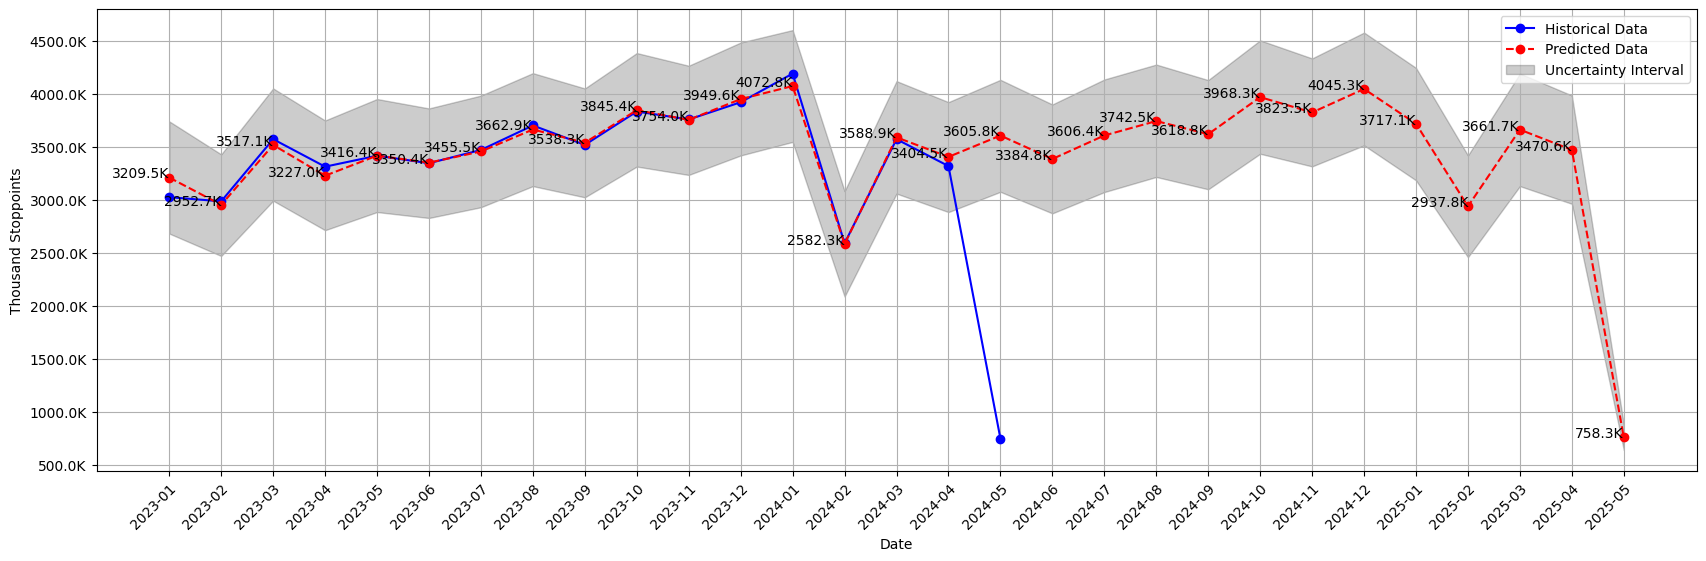

<Figure size 640x480 with 0 Axes>

In [9]:
df= forecast_gsv_bike_sgn.resample_and_plot_data(_df_forecast=df_forecast.copy(),start_date='2022-01-01')


### Export data
* call funtion export_data, provide dataframe, file type (excel or csv) and file name

In [10]:
# forecast_gsv_bike_sgn.export_data(df=df_forecast,file_name='gsv_bike_sgn',file_type='excel')
forecast_gsv_bike_sgn.export_data(df=df_forecast,file_name='stp_apr_24',file_type='csv')

Export data sucessfully!
